In [104]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [150]:
#clients = pd.read_csv('../data/df_final_demo.txt')
events_1 = pd.read_csv('../data/df_final_web_data_pt_1.txt')
events_2 = pd.read_csv('../data/df_final_web_data_pt_2.txt')
test = pd.read_csv('../data/df_final_experiment_clients.txt')

### Initial exploration

In [106]:
events_1.shape

(343141, 5)

In [107]:
events_2.shape

(412264, 5)

In [108]:
events = pd.concat([events_1, events_2])
events.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [109]:
events.shape

(755405, 5)

In [110]:
events.dtypes

client_id        int64
visitor_id      object
visit_id        object
process_step    object
date_time       object
dtype: object

In [151]:
test.shape

(70609, 2)

In [152]:
test.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


### Exploring numerical and categorical variables

In [111]:
events.select_dtypes("number").nunique()

client_id    120157
dtype: int64

In [112]:
events['process_step'].value_counts()

process_step
start      243945
step_1     163193
step_2     133062
step_3     112242
confirm    102963
Name: count, dtype: int64

In [113]:
events.columns

Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time'], dtype='object')

In [114]:
events_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step']
# ordinal: process_step
events_numerical = ['date_time']

In [115]:
events['date_time'] = pd.to_datetime(events['date_time'])

In [116]:
events.dtypes

client_id                int64
visitor_id              object
visit_id                object
process_step            object
date_time       datetime64[ns]
dtype: object

In [153]:
test['Variation'].value_counts()

Variation
Test       26968
Control    23532
Name: count, dtype: int64

### Data cleaning

In [117]:
events.isnull().sum()

client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64

In [118]:
events = events.drop_duplicates()

In [154]:
test.isnull().sum()

client_id        0
Variation    20109
dtype: int64

In [155]:
test.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [156]:
# Necesitamos solo los que estan en el experimento y 
test_in = test.dropna()
test_in['Variation'] = test_in['Variation'].apply(lambda x: 1 if x == 'Test' else 0)

C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_23572\3417416057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in['Variation'] = test_in['Variation'].apply(lambda x: 1 if x == 'Test' else 0)


In [157]:
# Necesitamos saber si estan en el experimento o no
test['experiment'] = test['Variation'].notnull().astype(int)

### Univariate Analysis

In [119]:
frequency_table = events["process_step"].value_counts()
frequency_table 

process_step
start      234999
step_1     162797
step_2     132750
step_3     111589
confirm    102506
Name: count, dtype: int64

In [120]:
table = pd.crosstab(index = events["process_step"],columns="count")
table 

col_0,count
process_step,
confirm,102506
start,234999
step_1,162797
step_2,132750
step_3,111589


In [121]:
(table/table.sum()).round(2)

col_0,count
process_step,
confirm,0.14
start,0.32
step_1,0.22
step_2,0.18
step_3,0.15


C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_23572\362503033.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequency_table.index, y=frequency_table.values, palette="Set3");


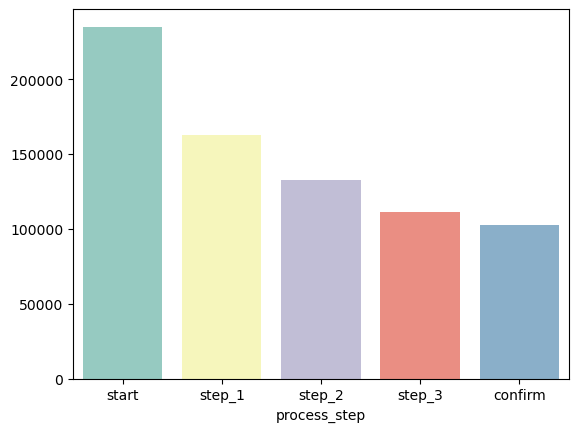

In [122]:
sns.barplot(x=frequency_table.index, y=frequency_table.values, palette="Set3");

plt.show()

C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_23572\1001904810.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=events, x='process_step', palette="Set3");


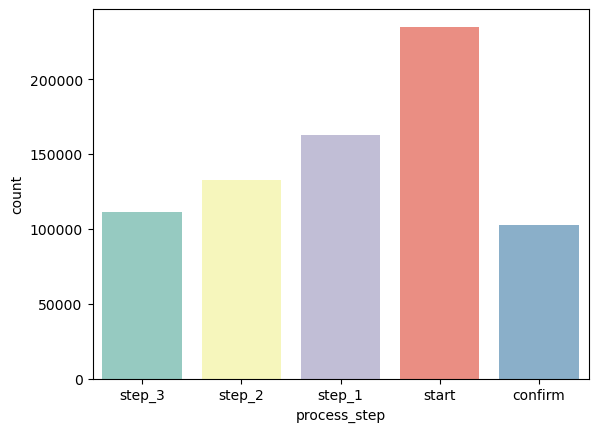

In [139]:
#sns.countplot(data=events, x='process_step', palette="Set3");
#plt.show()

###

In [127]:
events['process_step'].describe()

count     744641
unique         5
top        start
freq      234999
Name: process_step, dtype: object